# **LC25000 - Lung Cancer Classification using MobileNetV2 model**

In [1]:
import keras
print(keras.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

2.12.0


**Import Libraries**

In [2]:
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Dropout, Add
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense
from keras.utils import np_utils
#from keras.initializers import glorot_uniform
from keras import backend as K

import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
import cv2
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import math

**Loading Dataset and Images**

In [4]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (80,80))
            images.append(img)
            
    return np.array(images)

In [5]:
benign = load_images('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n')
mal_aca = load_images('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca')
mal_scc = load_images('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc')

In [6]:
print(f"Number of images for every class: BENIGN {benign.shape[0]}, ADENOCARCINOMAS {mal_aca.shape[0]}, SQUAMOS CELL CARCINOMAS {mal_scc.shape[0]}.")

Number of images for every class: BENIGN 5000, ADENOCARCINOMAS 5000, SQUAMOS CELL CARCINOMAS 5000.


In [7]:
print(f"Images shape: {benign[0].shape}.")

Images shape: (80, 80, 3).


In [8]:
# plot the first image for every class using subplot

In [9]:
samples = np.concatenate((benign, mal_aca, mal_scc))
labels = np.array(benign.shape[0] * [0] + mal_aca.shape[0] * [1] + mal_scc.shape[0] * [2])

In [10]:
print(f"Samples shape check: {samples.shape}.")
print(f"Labels shape check: {labels.shape}.")

Samples shape check: (15000, 80, 80, 3).
Labels shape check: (15000,).


In [11]:
indices = np.arange(samples.shape[0])
np.random.shuffle(indices)

samples = samples[indices]
labels = labels[indices]

# normalize pictures
samples = samples.astype('float32') / 255

**Train Test Validation Split**

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size = 0.2)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

In [13]:
Y_train = np_utils.to_categorical(y_train, 3)
Y_val = np_utils.to_categorical(y_val, 3)
Y_test = np_utils.to_categorical(y_test, 3)

print(Y_train[0])
print(f"Y_train shape after one hot encoding: {Y_val.shape}")
print(f"Y_train shape after one hot encoding: {X_val.shape}")

[0. 0. 1.]
Y_train shape after one hot encoding: (1500, 3)
Y_train shape after one hot encoding: (1500, 80, 80, 3)


# - **MobileNetV2**

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

def expansion_block(x, t, filters, block_id):
    x = layers.Conv2D(t * filters, (1, 1), padding='same', use_bias=False, name='expand_{0}'.format(block_id))(x)
    x = layers.BatchNormalization(name='expand_bn_{0}'.format(block_id))(x)
    return layers.ReLU(6., name='expand_relu_{0}'.format(block_id))(x)

def depthwise_block(x, stride, block_id):
    x = layers.DepthwiseConv2D((3, 3), strides=stride, padding='same', use_bias=False, name='dwconv_{0}'.format(block_id))(x)
    x = layers.BatchNormalization(name='dwconv_bn_{0}'.format(block_id))(x)
    return layers.ReLU(6., name='dwconv_relu_{0}'.format(block_id))(x)

def projection_block(x, out_channels, block_id):
    x = layers.Conv2D(out_channels, (1, 1), padding='same', use_bias=False, name='project_{0}'.format(block_id))(x)
    return layers.BatchNormalization(name='project_bn_{0}'.format(block_id))(x)

def Bottleneck(x, t, filters, out_channels, stride, block_id):
    y = expansion_block(x, t, filters, block_id)
    y = depthwise_block(y, stride, block_id)
    y = projection_block(y, out_channels, block_id)
    if y.shape[-1] == x.shape[-1] and stride == 1:
       y = layers.add([x, y])
    return y

def MobileNetV2(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(input_layer)
    x = layers.BatchNormalization(name='conv1_bn')(x)
    x = layers.ReLU(6, name='conv1_relu')(x)

    # Add the bottleneck layers
    t = 6  # expansion factor
    x = Bottleneck(x, t, 32, 16, 1, 1)
    x = Bottleneck(x, t, 16, 24, 2, 2)
    x = Bottleneck(x, t, 24, 24, 1, 3)
    x = Bottleneck(x, t, 24, 32, 2, 4)
    x = Bottleneck(x, t, 32, 32, 1, 5)
    x = Bottleneck(x, t, 32, 32, 1, 6)
    x = Bottleneck(x, t, 32, 64, 2, 7)
    x = Bottleneck(x, t, 64, 64, 1, 8)
    x = Bottleneck(x, t, 64, 64, 1, 9)
    x = Bottleneck(x, t, 64, 64, 1, 10)
    x = Bottleneck(x, t, 64, 96, 1, 11)
    x = Bottleneck(x, t, 96, 96, 1, 12)
    x = Bottleneck(x, t, 96, 96, 1, 13)
    x = Bottleneck(x, t, 96, 160, 2, 14)
    x = Bottleneck(x, t, 160, 160, 1, 15)
    x = Bottleneck(x, t, 160, 160, 1, 16)
    x = Bottleneck(x, t, 160, 320, 1, 17)

    x = layers.Conv2D(filters=1280, kernel_size=1, padding='same', use_bias=False, name='last_conv')(x)
    x = layers.BatchNormalization(name='last_bn')(x)
    x = layers.ReLU(6, name='last_relu')(x)
    x = layers.GlobalAveragePooling2D(name='global_average_pool')(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(input_layer, output_layer)
    return model

In [15]:
input_shape = (80, 80, 3) 
num_classes = 3  
model_4 = MobileNetV2(input_shape, num_classes)
model_4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 40, 40, 32)   864         ['input_1[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 40, 40, 32)   128         ['conv2d[0][0]']                 
                                                                                                  
 conv1_relu (ReLU)              (None, 40, 40, 32)   0           ['conv1_bn[0][0]']               
                                                                                              

In [16]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

history = model_4.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_val, Y_val))

Epoch 1/10
188/188 [==============================] - 228s 1s/step - loss: 0.3464 - accuracy: 0.8517 - val_loss: 2.1830 - val_accuracy: 0.3107
Epoch 2/10
188/188 [==============================] - 213s 1s/step - loss: 0.2083 - accuracy: 0.9159 - val_loss: 3.1818 - val_accuracy: 0.3107
Epoch 3/10
188/188 [==============================] - 211s 1s/step - loss: 0.1562 - accuracy: 0.9392 - val_loss: 4.0727 - val_accuracy: 0.3447
Epoch 4/10
188/188 [==============================] - 213s 1s/step - loss: 0.1195 - accuracy: 0.9542 - val_loss: 1.0290 - val_accuracy: 0.7247
Epoch 5/10
188/188 [==============================] - 209s 1s/step - loss: 0.1060 - accuracy: 0.9610 - val_loss: 0.4842 - val_accuracy: 0.8580
Epoch 6/10
188/188 [==============================] - 217s 1s/step - loss: 0.0877 - accuracy: 0.9644 - val_loss: 0.1805 - val_accuracy: 0.9380
Epoch 7/10
188/188 [==============================] - 214s 1s/step - loss: 0.0715 - accuracy: 0.9730 - val_loss: 0.4241 - val_accuracy: 0.9087

/tmp/ipykernel_32/3116035815.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


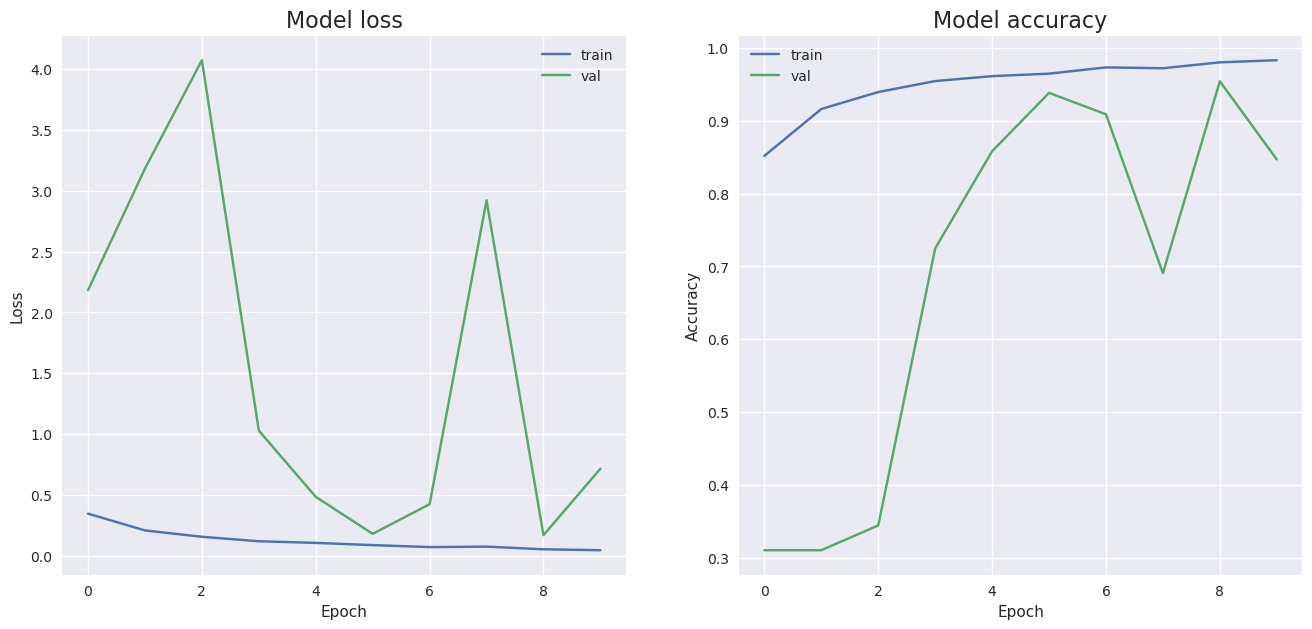

In [17]:
plt.style.use('seaborn')
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model loss', fontsize=16)  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model accuracy', fontsize=16)  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'])

plt.show()

In [18]:
y_pred_test = model_4.predict(X_test, verbose=1)
y_pred_train = model_4.predict(X_train, verbose=1)

# conversion to one hot encoding
#y_pred_test = (y_pred_test > 0.5).astype("int32")
#y_pred_train = (y_pred_train > 0.5).astype("int32")

# convert it to numerical classes
y_pred_test = np.argmax(y_pred_test, axis=1)
y_pred_train = np.argmax(y_pred_train, axis=1)

score_test = model_4.evaluate(X_test, Y_test)
print(f"Train accuracy: {history.history['accuracy'][-1]:.3f}")
print(f"Validation accuracy: {history.history['val_accuracy'][-1]:.3f}")
print(f"Test accuracy: {score_test[1]:.3f}")

47/47 [==============================] - 4s 87ms/step - loss: 0.6785 - accuracy: 0.8487
Train accuracy: 0.983
Validation accuracy: 0.847
Test accuracy: 0.849


<Axes: >

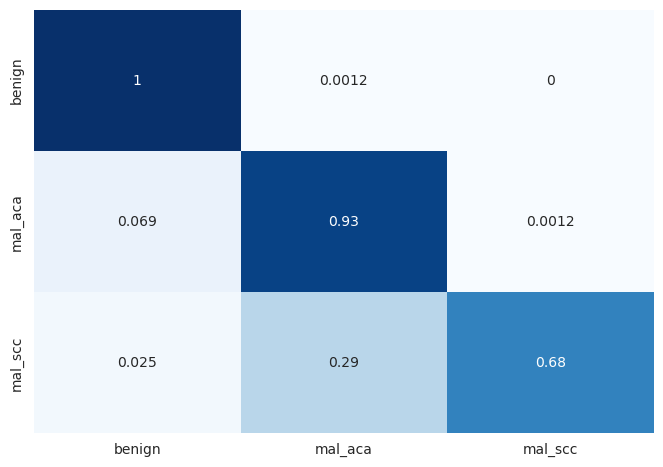

In [19]:
label_names = ['benign', 'mal_aca', 'mal_scc']


confmat = confusion_matrix(y_train, y_pred_train, normalize='true')
sn.heatmap(confmat, annot=True, cmap='Blues', cbar=False, 
           xticklabels=label_names, yticklabels=label_names)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report


# Classification report for training set
classification_report_train = classification_report(y_train, y_pred_train, target_names=label_names)

# Classification report for testing set
classification_report_test = classification_report(y_test, y_pred_test, target_names=label_names)

print("Training Set Classification Report:\n")
print(classification_report_train)

print("Testing Set Classification Report:\n")
print(classification_report_test)

Training Set Classification Report:

              precision    recall  f1-score   support

      benign       0.91      1.00      0.95      4009
     mal_aca       0.76      0.93      0.84      4012
     mal_scc       1.00      0.68      0.81      3979

    accuracy                           0.87     12000
   macro avg       0.89      0.87      0.87     12000
weighted avg       0.89      0.87      0.87     12000

Testing Set Classification Report:

              precision    recall  f1-score   support

      benign       0.88      1.00      0.94       474
     mal_aca       0.75      0.91      0.82       522
     mal_scc       0.99      0.64      0.78       504

    accuracy                           0.85      1500
   macro avg       0.87      0.85      0.85      1500
weighted avg       0.87      0.85      0.84      1500



**Mistakes**

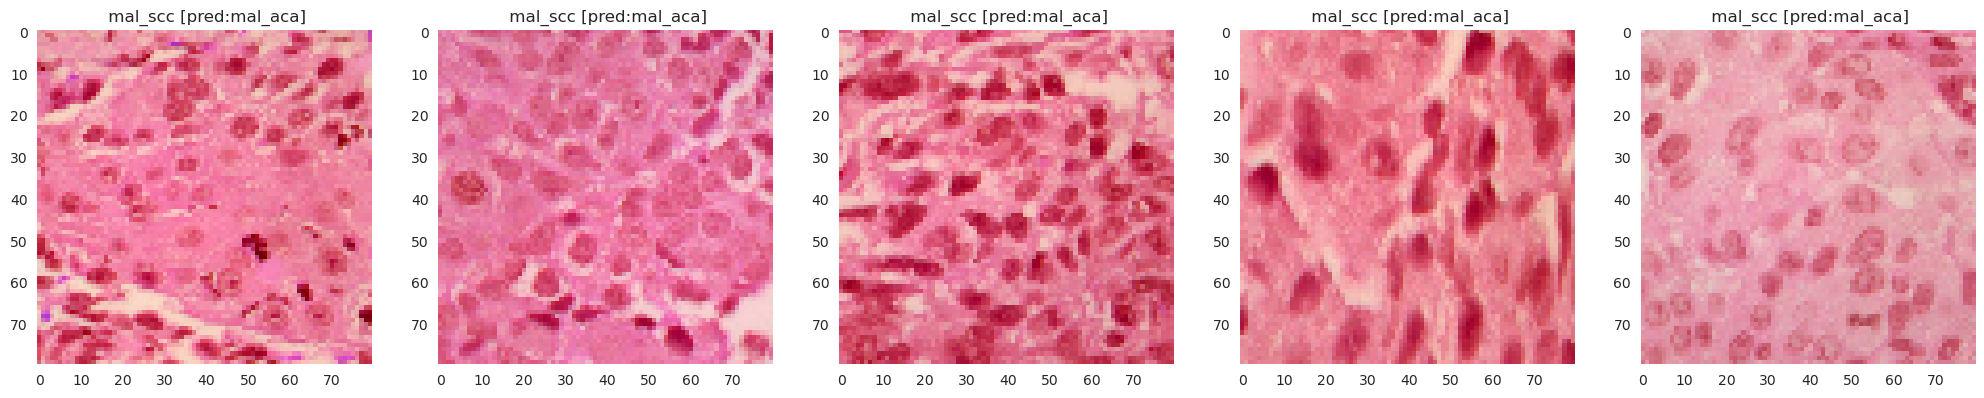

In [21]:
mistakes = np.where(y_pred_train != y_train)[0]

n = 5

plt.figure(figsize=(5*n,5))

# get 5 random false negatives
for i, val in enumerate(np.random.choice(mistakes, n)):

    plt.subplot(1,n,i+1)
    plt.imshow(X_train[val])
    plt.title(f" {label_names[y_train[val]]} [pred:{label_names[y_pred_train[val]]}]", fontsize=12)
    plt.grid(None)

In [22]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Get true classes for test and train datasets
y_true_test = np.argmax(Y_test, axis=1)
y_true_train = np.argmax(Y_train, axis=1)

# Calculate precision, recall, and F1 score for test and train datasets
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average='weighted')
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_true_train, y_pred_train, average='weighted')

# Print the results
print("Test set metrics:")
print(f"Precision: {precision_test:.3f}")
print(f"Recall: {recall_test:.3f}")
print(f"F1 Score: {f1_score_test:.3f}")

print("\nTrain set metrics:")
print(f"Precision: {precision_train:.3f}")
print(f"Recall: {recall_train:.3f}")
print(f"F1 Score: {f1_score_train:.3f}")


Test set metrics:
Precision: 0.872
Recall: 0.849
F1 Score: 0.844

Train set metrics:
Precision: 0.891
Recall: 0.871
F1 Score: 0.868
